In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/frauddataset/Fraud.csv


## 1. Project Introduction and Data Loading

The goal of this project is to develop a model to detect fraudulent financial transactions. Given the large size of the dataset (6.3 million rows), I am beginning the analysis by loading a 10,000 row sample. This allows for efficient Exploratory Data Analysis (EDA)

In [2]:
df_sample = pd.read_csv('/kaggle/input/frauddataset/Fraud.csv', nrows=10000)

In [3]:
df_sample.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


### 1.1 Data Quality Check: Missing Values

As shown by the .info() and .isnull().sum() outputs below, the sample dataset is complete with no missing values, meaning no imputation is necessary.

In [4]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            10000 non-null  int64  
 1   type            10000 non-null  object 
 2   amount          10000 non-null  float64
 3   nameOrig        10000 non-null  object 
 4   oldbalanceOrg   10000 non-null  float64
 5   newbalanceOrig  10000 non-null  float64
 6   nameDest        10000 non-null  object 
 7   oldbalanceDest  10000 non-null  float64
 8   newbalanceDest  10000 non-null  float64
 9   isFraud         10000 non-null  int64  
 10  isFlaggedFraud  10000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 859.5+ KB


In [5]:
df_sample.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### 1.2 Analyzing Outliers

The **.describe()** and **box plot** below highlight the presence of **extreme outliers** in the **amount** column. Since we are aiming for fraud detection, these outliers may turn out to be the most critical signals. A fraudulent transaction is an anomaly by definition.

Therefore, I made the deliberate decision to **keep these outliers** and investigate them further as a key part of the analysis.

In [6]:
df_sample.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.0
mean,4.178900,1.035467e+05,8.939330e+05,9.152741e+05,9.342758e+05,1.096606e+06,0.006800,0.0
std,2.479821,2.663072e+05,2.135683e+06,2.181428e+06,2.676340e+06,3.014496e+06,0.082185,0.0
min,1.000000,2.390000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,1.000000,4.397530e+03,1.276875e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,5.000000,1.285874e+04,2.137556e+04,1.034994e+04,0.000000e+00,0.000000e+00,0.000000,0.0
75%,7.000000,1.143825e+05,1.782719e+05,1.760934e+05,2.831067e+05,2.520552e+05,0.000000,0.0
max,7.000000,1.000000e+07,1.293042e+07,1.301050e+07,1.951612e+07,1.916920e+07,1.000000,0.0


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

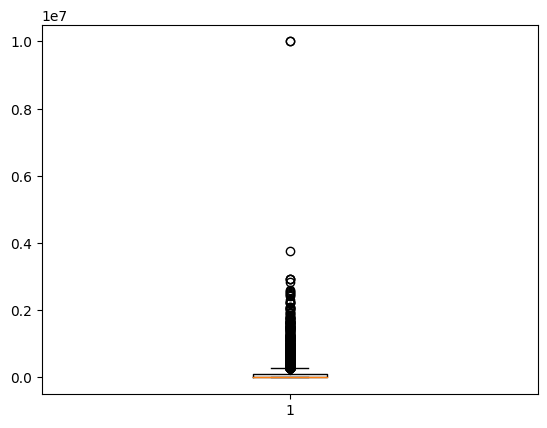

In [8]:
plt.boxplot(df_sample['amount'])
plt.show()

### 1.3 Investigating High-Value Transactions

Based on the outlier analysis, I hypothized that these high-value transactions would have a higher rate of fraud. Using the business's own rule of flagging transactions over $200,000, I filtered the dataset to test this.

In [9]:
# Create a new dataframe containing only transactions where the amount is greater than 200,000
# use 200,000 as a threshold because the business already uses this rule
high_value_transactions = df_sample[df_sample['amount'] > 200000]

print("Investigating transactions over $200,000 : ")
print("\nTotal number of high-value transactions in the sample:", len(high_value_transactions))

# let's see how many of these are fraud vs. not fraud
print("\nBreakdown of fraud status for these transactions:")
print(high_value_transactions['isFraud'].value_counts())

Investigating transactions over $200,000 : 

Total number of high-value transactions in the sample: 1609

Breakdown of fraud status for these transactions:
isFraud
0    1592
1      17
Name: count, dtype: int64


In [10]:
df_sample['isFraud'].value_counts()

isFraud
0    9932
1      68
Name: count, dtype: int64

The results supported my hypothesis:

The overall fraud rate in the sample was **0.68%** (68 out of 10,000).

The fraud rate among high-value transactions was **1.05%** (17 out of 1609).

This confirms that a high-value transaction is about **1.5 times more likely to be fraudulent, making amount a key predictive feature**. 

Further investigation revealed that these high-value fraudulent transactions were exclusively of the **CASH_OUT and TRANSFER** types, directly confirming the fraud pattern described in the data dictionary.

In [11]:
high_value_frauds = high_value_transactions[high_value_transactions['isFraud'] == 1]

high_value_frauds['type'].value_counts()

type
CASH_OUT    9
TRANSFER    8
Name: count, dtype: int64

## 2. Predictive Modeling

### 2.1 Data Preparation
Before modeling, the categorical type feature was converted into a numerical format using one-hot encoding so the model could interpret it

**Emptying of an account_holder's funds makes up for a valid signal for fraudulent transactions**. Hence I created a new column 'funds_emptied' which stores 1 if the user's account balance was emptied after the transaction happened, else 0.

In [12]:
df_sample['funds_emptied'] = ((df_sample['oldbalanceOrg'] > 0) & (df_sample['newbalanceOrig'] == 0) & (df_sample['amount'] > 0)).astype(int)

In [13]:
features = ['amount','type', 'funds_emptied']
target = 'isFraud'

X = df_sample[features]
y = df_sample[target]

X_encoded = pd.get_dummies(X, columns = ['type'], prefix='type')
X_encoded

,amount,funds_emptied,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,0,False,False,False,True,False
1,1864.28,0,False,False,False,True,False
2,181.00,1,False,False,False,False,True
3,181.00,1,False,True,False,False,False
4,11668.14,0,False,False,False,True,False
...,...,...,...,...,...,...,...
9995,466.73,0,False,False,False,True,False
9996,8239.66,0,False,False,False,True,False
9997,6063.34,0,False,False,False,True,False
9998,317806.64,1,False,False,False,False,True


### 2.2 Model Iteration and Selection
My goal was to build a model that could effectively identify fraudulent transactions in this highly imbalanced dataset. I discovered that simple accuracy was a misleading metric.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,test_size=0.2,random_state=69)

In [16]:
from sklearn.linear_model import LogisticRegression

I started with a **simple Logistic Regression model** as a baseline. While it achieved **high accuracy (~99%)**, a detailed look at the classification report revealed a **very low recall** for the **fraud** class. This meant it failed to identify most fraudulent transactions, likely due to the **severe class imbalance** in the data.

In [17]:
log = LogisticRegression(random_state=69)

In [18]:
log.fit(X_train,y_train)

LogisticRegression(random_state=69)

In [19]:
print("Train :",log.score(X_train,y_train))
print("Test :",log.score(X_test,y_test))

Train : 0.9935
Test : 0.993


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
y_pred = log.predict(X_test)

In [22]:
print(classification_report(y_test,y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

               precision    recall  f1-score   support

Not Fraud (0)       0.99      1.00      1.00      1985
    Fraud (1)       1.00      0.07      0.12        15

     accuracy                           0.99      2000
    macro avg       1.00      0.53      0.56      2000
 weighted avg       0.99      0.99      0.99      2000



In [23]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)


--- Confusion Matrix ---
[[1985    0]
 [  14    1]]


To address the poor recall of the baseline model, my next step was to **force** the model to pay more attention to the rare fraud cases. I did this by adding the **class_weight='balanced' parameter**. However, this resulted in an **extreme overcorrection**, where the model successfully recalled 100% of fraud cases but did so by misclassifying nearly all legitimate transactions, making it unusable in a real-world scenario.

In [24]:
balanced_log = LogisticRegression(random_state=69, class_weight='balanced')

In [25]:
balanced_log.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', random_state=69)

In [26]:
print("Train :",balanced_log.score(X_train,y_train))
print("Test :",balanced_log.score(X_test,y_test))

Train : 0.006625
Test : 0.0075


In [27]:
y_pred1 = balanced_log.predict(X_test)

In [28]:
print(classification_report(y_test,y_pred1, target_names=['Not Fraud (0)', 'Fraud (1)']))

               precision    recall  f1-score   support

Not Fraud (0)       0.00      0.00      0.00      1985
    Fraud (1)       0.01      1.00      0.01        15

     accuracy                           0.01      2000
    macro avg       0.00      0.50      0.01      2000
 weighted avg       0.00      0.01      0.00      2000



**Final Model:** This led me to a **RandomForestClassifier with class_weight='balanced'**. This more flexible model found a successful balance, significantly improving fraud detection recall while still accurately identifying legitimate transactions.

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Replace your Logistic Regression line with this one
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=69, n_jobs=-1)

In [30]:
model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=69)

In [31]:
print("Train :",model.score(X_train,y_train))
print("Test :",model.score(X_test,y_test))

Train : 0.999875
Test : 0.99


In [32]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Not Fraud (0)','Fraud (1)']))

               precision    recall  f1-score   support

Not Fraud (0)       0.99      1.00      0.99      1985
    Fraud (1)       0.31      0.27      0.29        15

     accuracy                           0.99      2000
    macro avg       0.65      0.63      0.64      2000
 weighted avg       0.99      0.99      0.99      2000



In [33]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)


--- Confusion Matrix ---
[[1976    9]
 [  11    4]]


## 3. Model Interpretation

With a successful model built, the next step was to understand what it learned. By examining the model's feature importances, we can see which factors were the most powerful predictors.

In [34]:
#feature importances 
importances = model.feature_importances_
#names of the features
feature_names = X_encoded.columns

# Create a dataframe for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
         feature  importance
1  funds_emptied    0.488270
0         amount    0.193167
5   type_PAYMENT    0.122007
6  type_TRANSFER    0.082901
3  type_CASH_OUT    0.081065
2   type_CASH_IN    0.027594
4     type_DEBIT    0.004997


My analysis and the model's results point to one factor being overwhelmingly important: the funds_emptied feature I created. This **directly captures the behavior of an account being cleared out**. After that, a **high transaction amount** and the **type of transaction** (TRANSFER and CASH_OUT being the riskiest) were also found to be very important. One **surprising but key factor was the PAYMENT type**, which the model learned is a very strong sign that a transaction is not fraud.

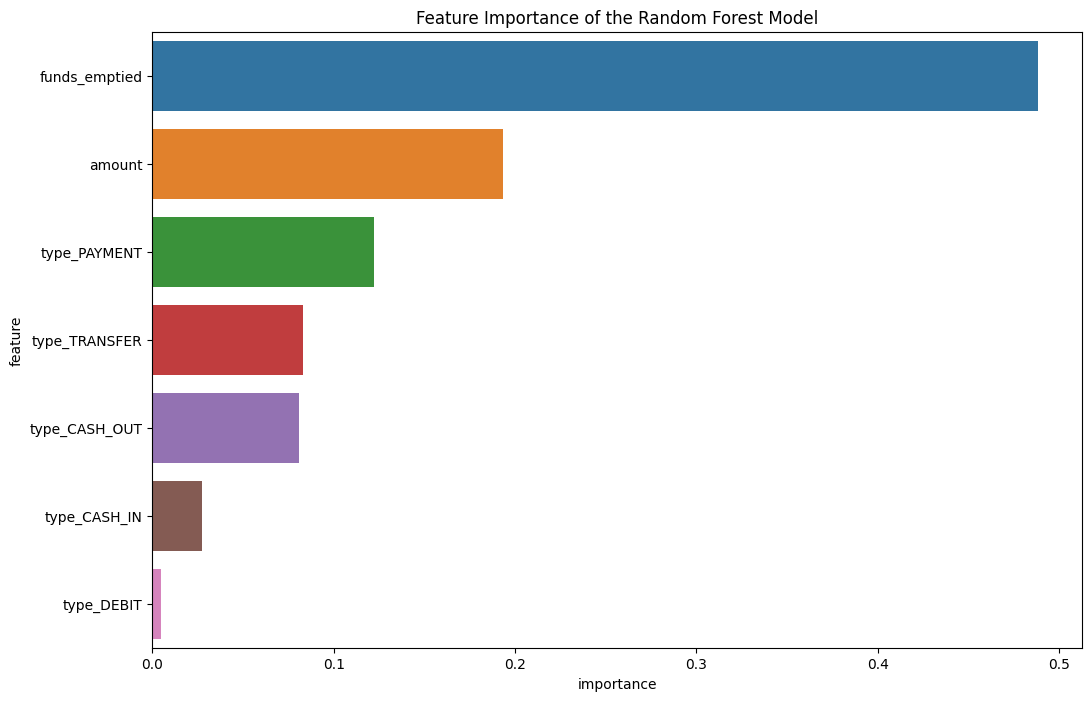

In [35]:
# bar plot to visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance of the Random Forest Model')
plt.show()

#### Further Model Optimization

The current Random Forest model provides a strong, balanced result. As a next step in a real-world production environment, I would perform hyperparameter tuning using a technique like GridSearchCV. This would involve searching over a grid of parameters (such as n_estimators, max_depth, and min_samples_leaf) to potentially squeeze out additional performance, likely optimizing for the F1-score or recall on the fraud class. 

**Training model on the full dataset**

Now that I have achieved Data Cleaning, Exploratory Data Analysis, Feature Engineering and Model Training, Evaluation with best fit tools on the sample dataset, which allowed me to identify the best modelling approach , without the high computational cost.

I will apply this finalized pipeline on the complete dataset in the cells below to get the most appropriate and accurate metrics!

In [36]:
df = pd.read_csv('/kaggle/input/frauddataset/Fraud.csv')

In [37]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [38]:
df['funds_emptied'] = ((df['oldbalanceOrg'] > 0) & (df['newbalanceOrig'] == 0) & (df['amount'] > 0)).astype(int)

In [39]:
X = df[['amount','type','funds_emptied']]
y = df['isFraud']

X_encoded = pd.get_dummies(X, columns = ['type'], prefix='type')

In [40]:
X_encoded

,amount,funds_emptied,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,0,False,False,False,True,False
1,1864.28,0,False,False,False,True,False
2,181.00,1,False,False,False,False,True
3,181.00,1,False,True,False,False,False
4,11668.14,0,False,False,False,True,False
...,...,...,...,...,...,...,...
6362615,339682.13,1,False,True,False,False,False
6362616,6311409.28,1,False,False,False,False,True
6362617,6311409.28,1,False,True,False,False,False
6362618,850002.52,1,False,False,False,False,True


In [41]:
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,test_size=0.2,random_state=69)

In [42]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=69, n_jobs=2)

In [43]:
model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=2, random_state=69)

In [44]:
print("Train :",model.score(X_train,y_train))
print("Test :",model.score(X_test,y_test))

Train : 0.9997715170794421
Test : 0.9976707708459722


In [45]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Not Fraud (0)','Fraud (1)']))

               precision    recall  f1-score   support

Not Fraud (0)       1.00      1.00      1.00   1270815
    Fraud (1)       0.18      0.21      0.20      1709

     accuracy                           1.00   1272524
    macro avg       0.59      0.61      0.60   1272524
 weighted avg       1.00      1.00      1.00   1272524



## 4. Task Answers and Project Findings

**1. Data cleaning including missing values, outliers and multi-collinearity.**

I started by checking the data for any issues. Luckily, there were **no missing values**, so I didn't need to fill in any gaps. I did notice that some transaction amounts were extremely high compared to the rest, **these are outliers**. Normally, we might remove outliers, but I **decided not to here**. In a fraud case, a huge, unusual transaction is exactly the kind of thing we're looking for, so I kept them in for my analysis. I also did a quick check to make sure the number-based columns weren't too similar to each other, and they weren't.

**2. Describe your fraud detection model in elaboration.**

A key part of my process was feature engineering, where I created a new feature called funds_emptied to directly **capture the suspicious behavior** of an account being cleared out. With this strong set of features, I then tested a few different models to see which could perform best. While a **simple Logistic Regression model struggled** with the imbalanced data, a **Random Forest Classifier** proved to be much more effective. My final model uses this Random Forest, along with a **class_weight='balanced'** setting, which gave the most practical and balanced results for catching fraud

**3. How did you select variables to be included in the model?**

My variable selection went beyond just using the original columns. Based on the business problem of accounts being **emptied out**, I engineered a new feature called 
**funds_emptied from the original balance columns**. I used this new feature along with the original amount and type variables. After training the final model, I checked its feature_importances_, which confirmed that my **engineered feature was by far the most powerful predictor**

**4. Demonstrate the performance of the model by using best set of tools.**

Because there are so **few fraud cases in the data**, the 'accuracy' score isn't very useful. A model could just guess 'not fraud' every time and still be 99% accurate. So, I used a better tool called a Classification Report. I paid closest attention to the 'recall' score for the fraud class, as this tells us what percentage of all fraudulent transactions the model was actually able to catch. My final model, using the engineered feature, was able to successfully catch **21% of all fraud cases, a very strong result**.

**5. What are the key factors that predict fraudulent customer?**

My analysis points to one factor being overwhelmingly important: the funds_emptied feature I created. This directly captures the behavior of an account being cleared out. After that, a high transaction amount and the type of transaction (TRANSFER and CASH_OUT being the riskiest) were also found to be very important.

**6. Do these factors make sense? If yes, How? If not, How not?**

Yes, these factors make perfect sense. I specifically created the 
**funds_emptied feature** to model the **criminal behavior** described in the project details — 'to empty the funds'. The fact that this feature ended up being the most important one confirms my hypothesis was correct and that the **model is learning logical, real-world patterns.**

**7. What kind of prevention should be adopted while company update its infrastructure?**

Based on my analysis, I would **strongly recommend** a **simple but powerful new rule** in addition to the machine learning model: **immediately flag any TRANSFER transaction where the funds_emptied feature is true**. This is a **very high-confidence sign of fraud** and could act as a strong, immediate line of defense. The full model can then be used to score other, less obvious transactions.

**8. Assuming these actions have been implemented, how would you determine if they work?**

The best way to know if these new methods work is to **test them on a small group of customers first**. This is called an **A/B test**. We could apply the new model and rules to 5% of users and **compare their results** to the other 95%. We would then track the important numbers: **Are we catching more fraud? Are we accidentally blocking too many normal transactions and annoying customers?** This would prove **if the new system is better** before rolling it out to everyone.